# Imports

In [1]:
pip install gpy

     |████████████████████████████████| 959 kB 4.8 MB/s 
     |████████████████████████████████| 71 kB 6.2 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565147 sha256=a0cc1feab4efd9ae7568605e63452f1dc00d6fc233c09b377b87904c9bf2cbcc
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=86bc6293a399a4e1fc8c8d014368782b7e56dfff5538b4b24f2ffa7316390e1d
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import GPy

from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import KNNImputer

In [3]:
sns.set(rc={'figure.figsize':(12,12)})

In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


# Importing Data

In [5]:
location = '/content/drive/My Drive/Colab Notebooks/dissertation/'

In [6]:
non_sep_cohort = pd.read_csv (location+'/FinalNonSepsisCohort.csv')
non_sep_series = pd.read_csv (location+'/FinalNonSepsisSeries.csv')
non_sep_series["Sepsis"] = 0

sep_cohort = pd.read_csv (location+'/FinalSepsisCohort.csv')
sep_series = pd.read_csv (location+'/FinalSepsisSeries.csv')
sep_series["Sepsis"] = 1

In [7]:
sep_series.rename(columns={"Temperature C (calc)": "Temperature C", "Total Bilirubin":"Total Bili"}, inplace=True)

Zina mentioned that age above 300 was set for data protection reasons, and this means that the individual is aged over 95. For this reason I set all instances of this to be 95.

In [8]:
non_sep_cohort["age"].replace(300,95,inplace=True)
sep_cohort["age"].replace(300,95,inplace=True)

# Exploring Data

## Nan value exploration and Feature Overlap

In [9]:
len(sep_series.columns) - len(non_sep_series.columns)

10

In [10]:
drop1 = [s for s in non_sep_series.columns if s not in sep_series.columns]
drop1
# This shows coluimns that exist in non_sepsis series but not in the sepsis series

['Arterial BP Mean',
 'Arterial BP [Diastolic]',
 'Arterial BP [Systolic]',
 'Respiratory Rate (spontaneous)',
 'SVI',
 'SVR',
 'SVRI',
 'SvO2']

In [11]:
drop2 = [s for s in sep_series.columns if s not in non_sep_series.columns]
drop2
# This shows coluimns that exist in sepsis series but not in the non_sepsis series

['weight',
 'Age',
 'Hour',
 'Admission Weight (Kg)',
 'Admission Weight (lbs.)',
 'Arterial CO2 Pressure',
 'Arterial O2 Saturation',
 'Arterial O2 pressure',
 'C-Reactive Protein',
 'Central Venous O2% Sat',
 'Central Venous Pressure',
 'D-Dimer',
 'Height',
 'Height (cm)',
 'Inspired O2 Fraction',
 'O2 saturation pulseoxymetry',
 'Platelet Count',
 'Venous PvCO2']

## Initial Distribution Investigation

### Patient ID Distributions

In [12]:
non_sep_series["Mortality14Days"].value_counts()
1872 / 45216
#death rate

0.041401273885350316

In [13]:
sep_series["Mortality14Days"].value_counts()
384 / 2640
#death rate

0.14545454545454545

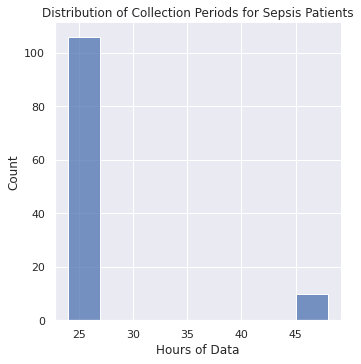

In [14]:
sns.displot(sep_series["PatientID"].value_counts()).set(title='Distribution of Collection Periods for Sepsis Patients', xlabel='Hours of Data')

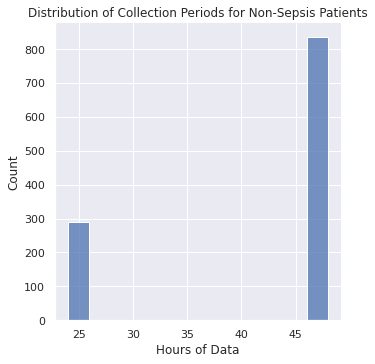

In [15]:
sns.displot(non_sep_series["PatientID"].value_counts()).set(title='Distribution of Collection Periods for Non-Sepsis Patients', xlabel='Hours of Data')

Shown above is how the number of patient hours are distributed. (Far more 48 hour windows than 24, but these are more concentrated within the non sepsis category than the sepsis one.)

### Plotting Blood Pressure Features

I noticed that the distributions of NaN values were not equal through the NBP feature in each data set.

The idea is to investigate the distribution of values between the NBP features (over both cohorts) and the "Arterial BP" features in one of the data sets. If these can be combined it would result in a lot more useable data.

In [16]:
non_sep_series["Arterial BP Mean"].describe()

count    31415.000000
mean        77.058157
std         14.324177
min          0.000000
25%         68.000000
50%         75.000000
75%         84.000000
max        287.000000
Name: Arterial BP Mean, dtype: float64

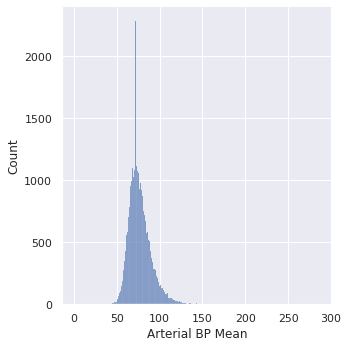

In [17]:
ax = sns.displot(non_sep_series, x="Arterial BP Mean")

In [18]:
sep_series["NBP Mean"].describe()

count    827.000000
mean      72.141880
std       14.374612
min        0.000000
25%       62.833349
50%       71.000000
75%       80.000000
max      145.332993
Name: NBP Mean, dtype: float64

 /usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning:`displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.


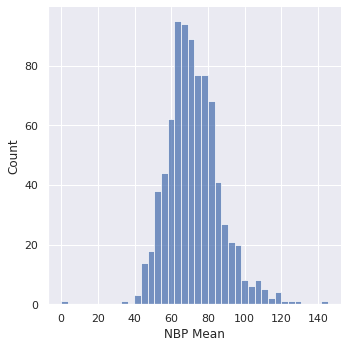

In [19]:
sns.displot(sep_series, x="NBP Mean", ax= ax)

- The mean features seem to be exchangeable.

## Combining Data Sets

In [20]:
#Dynamic Variables list, maybe change / improve on these but this is what Zina suggested:
# ALT | AST |Albumin | Arterial | PaCO2 | Arterial | PaO2 | Arterial pH | BUN |
# CVP | Central Venous Pressure | Chloride | Creatinine | Daily Weight |
# Fibrinogen | Glucose | Heart Rate | Hemoglobin | INR | Magnesium | NBP Mean |
# NBP [Diastolic] | NBP [Systolic] | O2 saturation pulseoxymetry | PTT |
# Platelet Count | Platelets | Potassium | Sodium |SpO2 | Temperature C (calc) | WBC

# Not all of the above seem to exist in my data set? Not sure why but worth just doing it myself.

In [21]:
combined_df = pd.concat([sep_series, non_sep_series], join="inner", ignore_index = True)
combined_df

,PatientID,comorbidity,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial PaCO2,Arterial PaO2,Arterial pH,BUN,CVP,CaO2,Chloride,Creatinine,Daily Weight,Fibrinogen,Glucose,Heart Rate,Hemoglobin,INR,Ionized Calcium,LDH,Magnesium,NBP Mean,NBP [Diastolic],NBP [Systolic],PTT,Platelets,Potassium,Resp Rate (Spont),SaO2,Sodium,SpO2,Temperature C,Total Bili,WBC,Day,OrdinalHour,Sepsis
0,168967.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.199997,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,65.666702,51.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,96.0,35.000000,NaN,NaN,0.0,0.0,1
1,168967.0,27.0,1.0,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,110.0,NaN,NaN,NaN,NaN,NaN,70.000000,44.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN,93.0,36.777802,NaN,NaN,0.0,1.0,1
2,168967.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,NaN,NaN,NaN,63.666698,48.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,1
3,168967.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,NaN,NaN,NaN,62.333302,25.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,77.0,NaN,NaN,NaN,0.0,3.0,1
4,168967.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,NaN,1.7,NaN,NaN,NaN,41.000000,25.0,73.0,97.9,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50107,159740.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,19.0,0
50108,159740.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,20.0,0
50109,159740.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,21.0,0
50110,159740.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,22.0,0


In [22]:
(combined_df.isnull().mean() * 100)
# excluding the 0 nan columns like ID, sepsis etc
# The average nan percentage of the columns is 86%

PatientID             0.000000
comorbidity           0.000000
Mortality14Days       0.000000
ALT                  98.926405
AST                  98.932391
Admit Ht             98.537277
Albumin              99.413314
Arterial PaCO2       82.660840
Arterial PaO2        82.698755
Arterial pH          81.579262
BUN                  95.781450
CVP                  43.799888
CaO2                 92.662436
Chloride             96.248404
Creatinine           95.773467
Daily Weight         97.968550
Fibrinogen           98.798691
Glucose              83.780332
Heart Rate           29.843151
Hemoglobin           92.776181
INR                  96.006944
Ionized Calcium      86.911319
LDH                  99.455220
Magnesium            95.973020
NBP Mean             87.565852
NBP [Diastolic]      87.434148
NBP [Systolic]       87.390246
PTT                  95.951070
Platelets            93.310983
Potassium            88.288234
Resp Rate (Spont)    91.736510
SaO2                 91.287516
Sodium  

## Old Investigation into NaN Percentages

In [23]:
combined_df["PID"] = combined_df["PatientID"]
combined_df["PID2"] = combined_df["PatientID"]

In [24]:
filled = combined_df.groupby(['PID']).ffill()

In [25]:
filled = filled.groupby(['PID2']).bfill()

In [26]:
frame1 = ((((filled[filled["Sepsis"]==1].isnull().mean() * 100) - 100 ) * -1))
frame1["Diagnosis"] = 1
frame2 = ((((filled[filled["Sepsis"]==0].isnull().mean() * 100) - 100 ) * -1))
frame2["Diagnosis"] = 0

In [27]:
nan_pcts = pd.DataFrame(columns = ["Sepsis", "Non Sepsis"])
nan_pcts["Sepsis"] = frame1
nan_pcts["Non Sepsis"] = frame2

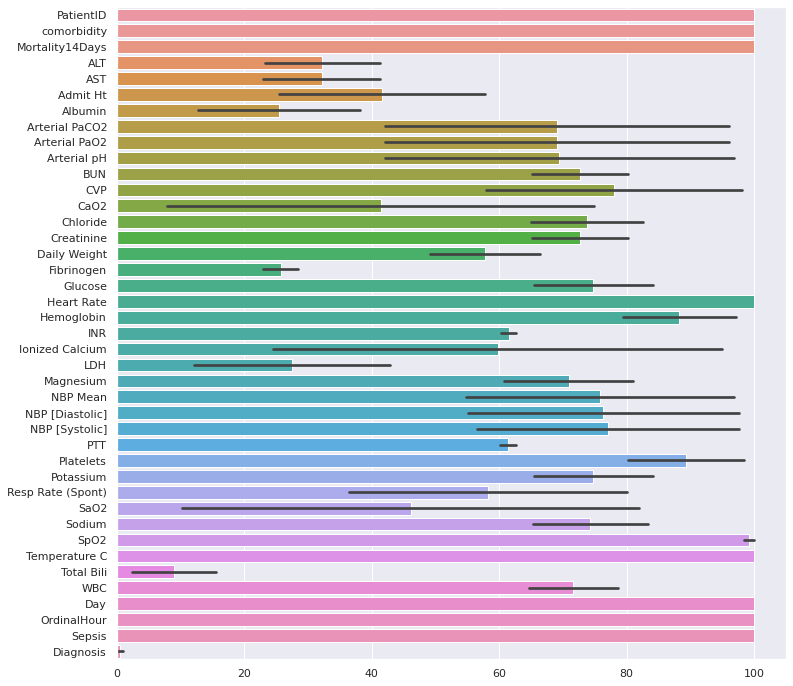

In [28]:
ax = sns.barplot(data=nan_pcts.T.reset_index(drop=True), orient="h")

- This above plot shows the percentage of patients that we have data for, averaged over both sepsis and non sepsis.
- Where there is a large line on the bar that means that there is a discrepancy between what portion of patients we have data for if they are in sepsis or non sepsis category.
- Eg for something like CaO2, in thye non sepsis series we have data for 74% of patients, but in the sepsis we only have data for 8% of patients.
- Why would this be??

In [29]:
# From above data we can select only where there is over 40% of data from both data sets.
# Could actually have different thresholds of data set size for each cohort, because non sepsis is much bigger.
# There is almost 10 * more non sepsis patients than there are sepsis. 
# This means we should take any data where sepsis patient percentage is higher than 40% as non sepsis is always more than 10%.

# Using this bit of code
nan_pcts["Sepsis"] > 40
# We can see that the only columns not to take are:
# ["Admit Ht", "Albumin", "CaO2", "Fibrinogen", "Ionized Calcium", "Resp Rate (Spont)", "SaO2", "Total Bili"]

PatientID             True
comorbidity           True
Mortality14Days       True
ALT                   True
AST                   True
Admit Ht             False
Albumin              False
Arterial PaCO2        True
Arterial PaO2         True
Arterial pH           True
BUN                   True
CVP                   True
CaO2                 False
Chloride              True
Creatinine            True
Daily Weight          True
Fibrinogen           False
Glucose               True
Heart Rate            True
Hemoglobin            True
INR                   True
Ionized Calcium      False
LDH                   True
Magnesium             True
NBP Mean              True
NBP [Diastolic]       True
NBP [Systolic]        True
PTT                   True
Platelets             True
Potassium             True
Resp Rate (Spont)    False
SaO2                 False
Sodium                True
SpO2                  True
Temperature C         True
Total Bili           False
WBC                   True
D

In [30]:
# I've added to this ALT, AST, LDH as they have high (over 70%) missing data values still.
filled.drop(columns=["ALT", "AST", "LDH", "Admit Ht", "Albumin", "CaO2", "Fibrinogen", "Ionized Calcium", "Resp Rate (Spont)", "SaO2", "Total Bili"], inplace=True)

In [31]:
last_entries = filled[filled["OrdinalHour"] == 23]

In [32]:
last_entries.drop_duplicates(subset=['PatientID'], keep="last", inplace=True)

 /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
last_entries["Sepsis"].value_counts()

0    1126
1     116
Name: Sepsis, dtype: int64

Looking at the number of patients we have in each class that do not have any data for this list of features.

In [34]:
(last_entries[last_entries["Sepsis"]==1].isnull().mean() * 100)

PatientID           0.000000
comorbidity         0.000000
Mortality14Days     0.000000
Arterial PaCO2     58.620690
Arterial PaO2      58.620690
Arterial pH        58.620690
BUN                21.551724
CVP                43.965517
Chloride           18.965517
Creatinine         21.551724
Daily Weight       50.000000
Glucose            17.241379
Heart Rate          0.000000
Hemoglobin         22.413793
INR                39.655172
Magnesium          20.689655
NBP Mean            3.448276
NBP [Diastolic]     2.586207
NBP [Systolic]      2.586207
PTT                39.655172
Platelets          21.551724
Potassium          17.241379
Sodium             18.103448
SpO2                1.724138
Temperature C       0.000000
WBC                23.275862
Day                 0.000000
OrdinalHour         0.000000
Sepsis              0.000000
dtype: float64

In [35]:
(last_entries[last_entries["Sepsis"]==0].isnull().mean() * 100)

PatientID           0.000000
comorbidity         0.000000
Mortality14Days     0.000000
Arterial PaCO2      4.529307
Arterial PaO2       4.529307
Arterial pH         3.818828
BUN                34.458259
CVP                 3.197158
Chloride           34.547069
Creatinine         34.458259
Daily Weight       36.234458
Glucose            33.925400
Heart Rate          0.000000
Hemoglobin          3.996448
INR                39.253996
Magnesium          39.520426
NBP Mean           46.092362
NBP [Diastolic]    45.825933
NBP [Systolic]     44.493783
PTT                39.431616
Platelets           2.220249
Potassium          33.836590
Sodium             34.103020
SpO2                0.000000
Temperature C       0.000000
WBC                35.079929
Day                 0.000000
OrdinalHour         0.000000
Sepsis              0.000000
dtype: float64

In [36]:
# As there are still a huge number of missing values I will also drop more columns
# This is rough and just to get a working model quickly. Probably worth going back over this and fixing later.
last_entries.drop(columns=["Arterial PaCO2","Arterial PaO2","Arterial pH","CVP"], inplace=True)

 /usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Investigating Each Column Independently

In [37]:
def remove_where(column, upper=False, lower=False):
    # Uses the combined_df dataframe.
    # Given an upper bound and a lower bound, will remove all entries from this 
    # feature where instances have a value above or below (respectively) this bound
    print("Searching through ", column)
    if not isinstance(upper, bool):
        print("Found ", len(combined_df[combined_df[column] > upper].index), "values above this range.")
        for ind in (combined_df[combined_df[column] > upper].index):
            combined_df.at[ind, column] = np.nan
    if not isinstance(lower, bool):
        print("Found ", len(combined_df[combined_df[column] < lower].index), "values below this range.")
        for ind in (combined_df[combined_df[column] < lower].index):
            combined_df.at[ind, column] = np.nan

    print("Succesfully replaced values outside this range with nans.")
    print()

Columns to investigate are:


```
'BUN','Chloride','Creatinine','Glucose','Heart Rate','Hemoglobin',
'INR','Magnesium','NBP Mean','NBP [Diastolic]','NBP [Systolic]',
'PTT','Platelets','Potassium','Sodium','SpO2','Temperature C','WBC'
```

In [38]:
columns_to_plot = [ 'BUN',
 'Chloride',
 'Creatinine',
 'Glucose',
 'Heart Rate',
 'Hemoglobin',
 'INR',
 'Magnesium',
 'NBP Mean',
 'NBP [Diastolic]',
 'NBP [Systolic]',
 'PTT',
 'Platelets',
 'Potassium',
 'Sodium',
 'SpO2',
 'Temperature C',
 'WBC',]

### "comorbidity"

- This column has been added by Zina, so does not need to be investigated. There are no nans and it is a sum of the number of comorbidities that each individual has.

### "BUN"

Blood Urea Nitrogen

- A BUN test is done to see how well your kidneys are working. If your kidneys are not able to remove urea from the blood normally, your BUN level rises. Heart failure, dehydration, or a diet high in protein can also make your BUN level higher. Liver disease or damage can lower your BUN level. A low BUN level can occur normally in the second or third trimester of pregnancy.

- A BUN test may be done with a blood creatinine test. The level of creatinine in your blood also tells how well your kidneys are working—a high creatinine level may mean your kidneys are not working properly. Blood urea nitrogen (BUN) and creatinine tests can be used together to find the BUN-to-creatinine ratio (BUN:creatinine). A BUN-to-creatinine ratio can help your doctor check for problems, such as dehydration, that may cause abnormal BUN and creatinine levels.

In [39]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["BUN"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["BUN"].isnull().mean())

Percent of null values in non sepsis :  0.34458259325044405
Percent of null values in sepsis :  0.21551724137931033


- About the same number of null values over both sepsis and non sepsis series. This is a good sign as it means we are able to combine these two together. 13% more patients in the non sepsis category have null values. This may be because the sepsis patients require further testing?

As shown below, the mean and STD of the column over sep and non sep are both roughly similar. (Within each quartile). The max and minimum are also not too far from each other. This seems to be a good sign as they can be combined. The shape of the distribution also seems okay, there are high value instances towards the upper end of the distribution, but this should be fine.

In [40]:
non_sep_series["BUN"].describe()

count    1978.000000
mean       24.094034
std        14.906156
min         3.000000
25%        14.000000
50%        20.000000
75%        31.000000
max       143.000000
Name: BUN, dtype: float64

In [41]:
sep_series["BUN"].describe()

count    136.000000
mean      39.014706
std       24.975243
min        9.000000
25%       20.750000
50%       33.500000
75%       51.000000
max      136.000000
Name: BUN, dtype: float64

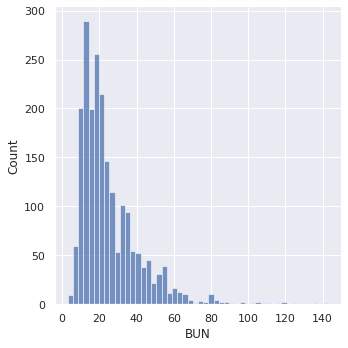

In [42]:
sns.displot(combined_df["BUN"])

### "Chloride"

- A chloride blood test measures the amount of chloride in your blood. Chloride is a type of electrolyte. Electrolytes are electrically charged minerals that help control the amount of fluids and the balance of acids and bases in your body. Chloride is often measured along with other electrolytes to diagnose or monitor conditions such as kidney disease, heart failure, liver disease, and high blood pressure.

In [43]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Chloride"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Chloride"].isnull().mean())

Percent of null values in non sepsis :  0.34547069271758435
Percent of null values in sepsis :  0.1896551724137931


Again, fairly similar percentage of null values, with a slight increase in the non sepsis patients. Again this could be because towards the end of data collection the sepsis patients are in a greater need of urgent care.

In [44]:
non_sep_series["Chloride"].describe()

count    1741.000000
mean      107.547961
std         4.878126
min        87.000000
25%       105.000000
50%       108.000000
75%       111.000000
max       133.000000
Name: Chloride, dtype: float64

In [45]:
sep_series["Chloride"].describe()

count    139.000000
mean     107.417266
std        6.796098
min       88.000000
25%      102.500000
50%      107.000000
75%      112.000000
max      125.000000
Name: Chloride, dtype: float64

- The Q values as well as the mean and STD do not seem vastly different for sepsis / non sepsis.

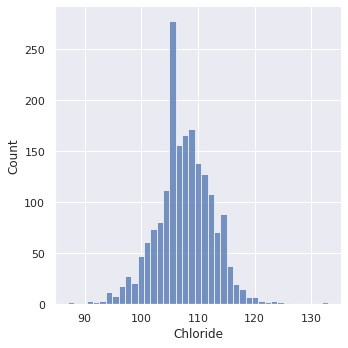

In [46]:
sns.displot(combined_df["Chloride"])

- Interesting to note that there are so many instances with a value of ~106. Presumably this is why the mean value for both sepsis and non sepsis is 107. This may be worth investigating further but I do not understand the reason for its frequency.

### "Creatinine"

- A creatinine blood test measures the level of creatinine in the blood. Creatinine is a waste product that forms when creatine, which is found in your muscle, breaks down. Creatinine levels in the blood can provide your doctor with information about how well your kidneys are working.

In [47]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Creatinine"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Creatinine"].isnull().mean())

Percent of null values in non sepsis :  0.34458259325044405
Percent of null values in sepsis :  0.21551724137931033


- Again the trend of 14% more null values in non sepsis patients, probably for similar reasons as stated before.

In [48]:
non_sep_series["Creatinine"].describe()

count    1982.000000
mean        1.475732
std         1.330165
min         0.200000
25%         0.800000
50%         1.100000
75%         1.500000
max        12.500000
Name: Creatinine, dtype: float64

In [49]:
sep_series["Creatinine"].describe()

count    136.000000
mean       1.890441
std        1.428228
min        0.200000
25%        1.000000
50%        1.500000
75%        2.425000
max        7.000000
Name: Creatinine, dtype: float64

- Definitely some outliers in the non sepsis series. The 12.5 value is far higher than the Q3 in either sepsis diagnosis category. This may be worth investigating. Interestingly, although there are more values in the non sepsis series that are > 6, the actual mean value for sepsis patients is higher. 

In [50]:
(non_sep_series["Creatinine"] > 8).value_counts()

False    47077
True        11
Name: Creatinine, dtype: int64

In [51]:
(sep_series["Creatinine"] > 8).value_counts()

False    3024
Name: Creatinine, dtype: int64

- There are only 38 instances where the values are > 6 for this column. It might be worth removing all instances of these.

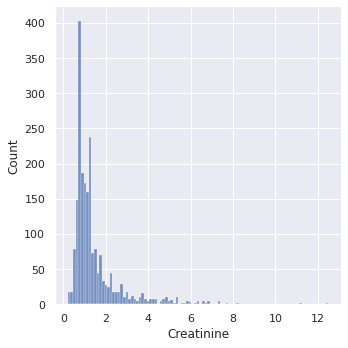

In [52]:
sns.displot(combined_df["Creatinine"])

This distribution shows that the large majority of these values are clustered between 0 and 4, and that there are very few that extend beyond this.

In [53]:
#remove_where("Creatinine", upper=8)

In [54]:
#sns.displot(combined_df["Creatinine"])

### "Glucose"

In [55]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Glucose"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Glucose"].isnull().mean())

Percent of null values in non sepsis :  0.3392539964476021
Percent of null values in sepsis :  0.1724137931034483


- Again, higher number of patients never tested for Glucose in the non sepsis category.

In [56]:
non_sep_series["Glucose"].describe()

count    7978.000000
mean      125.757458
std        40.834841
min        26.000000
25%       101.000000
50%       119.000000
75%       142.000000
max       638.000000
Name: Glucose, dtype: float64

In [57]:
sep_series["Glucose"].describe()

count    150.000000
mean     144.613333
std       56.558194
min       62.000000
25%      102.250000
50%      133.500000
75%      169.500000
max      338.000000
Name: Glucose, dtype: float64

- Similar mean and STD values for the Glucose column.
- There does seem, however, to be far higher maximum values in the non sepsis patients. This is similar to creatinine as the sepsis mean is higher but the max is much larger for the non sepsis patients.
- Worth investigating and potentially removing the values that extend beyond a certain point.

In [58]:
(non_sep_series["Glucose"] > 400).value_counts()

False    47072
True        16
Name: Glucose, dtype: int64

In [59]:
(sep_series["Glucose"] > 400).value_counts()

False    3024
Name: Glucose, dtype: int64

- To cause this to be normally distributed would only be losing 45 entries, 42 of which are in the non sepsis category.

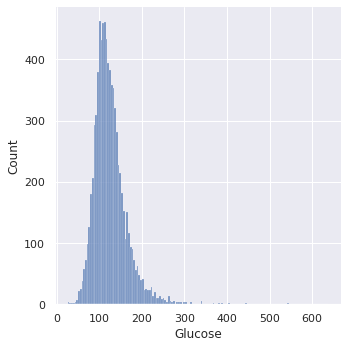

In [60]:
sns.displot(combined_df["Glucose"])

- This distribution plot might point to the need for the removal of these high value instances, as it would cause the plot to be far more normally distributed and might aid in increasing the efficacy of the model.

In [61]:
#remove_where("Glucose", upper=400)

In [62]:
#sns.displot(combined_df["Glucose"])

### "Heart Rate"

In [63]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Heart Rate"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Heart Rate"].isnull().mean())

Percent of null values in non sepsis :  0.0
Percent of null values in sepsis :  0.0


- Thankfully we have no NaN values in either sepsis or non sepsis for heart rate data.

In [64]:
non_sep_series["Heart Rate"].describe()

count    34081.000000
mean        86.659987
std         14.619726
min          0.000000
25%         78.000000
50%         86.000000
75%         95.000000
max        223.000000
Name: Heart Rate, dtype: float64

In [65]:
sep_series["Heart Rate"].describe()

count    1076.000000
mean       92.454461
std        18.061568
min        47.000000
25%        80.000000
50%        92.000000
75%       106.000000
max       162.000000
Name: Heart Rate, dtype: float64

- The minimum heart rate value of 0 is quite worrying, unless it is after death but this is worth investigating. Presumably we can drop it even if it is measured after death as we won't be too interesting in predicting sepsis at this point.
- Other than that the mean and STD are fairly similar over both categories. The Quartile values as well as the maximum are fairly similar.

In [66]:
(non_sep_series["Heart Rate"] > 200).value_counts()

False    47084
True         4
Name: Heart Rate, dtype: int64

In [67]:
(non_sep_series["Heart Rate"] < 45).value_counts()

False    47051
True        37
Name: Heart Rate, dtype: int64

In [68]:
(non_sep_series["Heart Rate"] == 0).value_counts()

False    47084
True         4
Name: Heart Rate, dtype: int64

In [69]:
(sep_series["Heart Rate"] > 200).value_counts()

False    3024
Name: Heart Rate, dtype: int64

In [70]:
(sep_series["Heart Rate"] < 45).value_counts()

False    3024
Name: Heart Rate, dtype: int64

- All the sepsis patients are within the 45 to 200 range, and all but 41 of the non sepsis entries fit this range also. It may be worth removing instances that do not fit this description. 

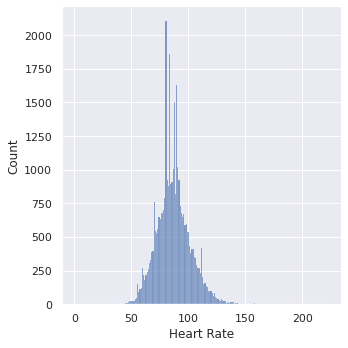

In [71]:
sns.displot(combined_df["Heart Rate"])

- We can assume that as this data set is of elderly people who are already in the intensive care unit - they wouldn't have a heart rate that varies outside of 45 - 200 BPM. With this knowledge we can probably drop the entries that are outside of this range. 
- Im not sure why there are so many entries in these spikes where the count can exceed 2000 entries.

In [72]:
remove_where("Heart Rate", upper=200, lower=45)

Searching through  Heart Rate
Found  4 values above this range.
Found  37 values below this range.
Succesfully replaced values outside this range with nans.



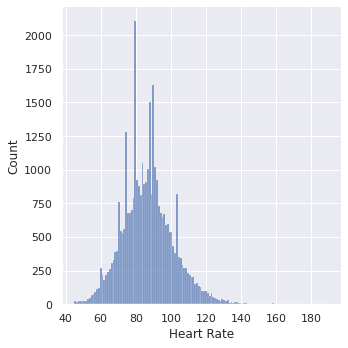

In [73]:
sns.displot(combined_df["Heart Rate"])

### "Hemoglobin"

- A hemoglobin test measures the levels of hemoglobin in your blood. Hemoglobin is a protein in your red blood cells that carries oxygen from your lungs to the rest of your body. If your hemoglobin levels are abnormal, it may be a sign that you have a blood disorder. A hemoglobin test is often used to check for anemia, a condition in which your body has fewer red blood cells than normal. 

In [74]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Hemoglobin"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Hemoglobin"].isnull().mean())

Percent of null values in non sepsis :  0.03996447602131439
Percent of null values in sepsis :  0.22413793103448276


Interestingly, there are far more patients with no hemoglobin data in the sepsis category. This may be a column worth removing from the data set, as otherwise it will heavily bias the existence of hemoglobin data towards not having a sepsis diagnosis.

In [75]:
non_sep_series["Hemoglobin"].describe()

count    3487.000000
mean       10.381594
std         1.536069
min         0.000000
25%         9.400000
50%        10.300000
75%        11.200000
max        19.100000
Name: Hemoglobin, dtype: float64

In [76]:
sep_series["Hemoglobin"].describe()

count    133.000000
mean      10.442857
std        1.651413
min        6.800000
25%        9.400000
50%       10.300000
75%       11.700000
max       15.800000
Name: Hemoglobin, dtype: float64

The mean and standard deviation, and quartiles of this column are all very similar. THe maximum value is fairly similar also, but the minimum value for non sepsis is far lower than that of sepsis.

In [77]:
(non_sep_series["Hemoglobin"] < 3).value_counts()

False    47086
True         2
Name: Hemoglobin, dtype: int64

There are only 5 entries where the value for this column is less than 5, because of this we could think about dropping these entries. This would make the range of values more normally distributed.

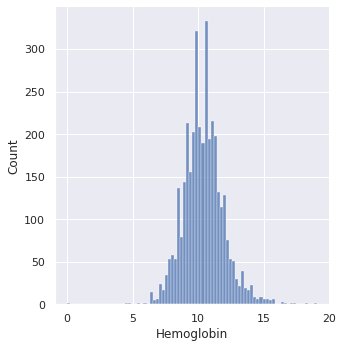

In [78]:
sns.displot(combined_df["Hemoglobin"])

In [79]:
#remove_where("Hemoglobin", lower=5)

In [80]:
#sns.displot(combined_df["Hemoglobin"])

### "INR"

- A prothrombin time (PT) test measures how long it takes for a clot to form in a blood sample. An INR (international normalized ratio) is a type of calculation based on PT test results.

- Prothrombin is a protein made by the liver. It is one of several substances known as clotting (coagulation) factors. When you get a cut or other injury that causes bleeding, your clotting factors work together to form a blood clot. Clotting factor levels that are too low can cause you to bleed too much after an injury. Levels that are too high can cause dangerous clots to form in your arteries or veins.

In [81]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["INR"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["INR"].isnull().mean())

Percent of null values in non sepsis :  0.3925399644760213
Percent of null values in sepsis :  0.39655172413793105


- Very similar percentage of null values, which is a good sign although it is rather high.

In [82]:
non_sep_series["INR"].describe()

count    1909.000000
mean        1.459246
std         0.857355
min         0.600000
25%         1.200000
50%         1.300000
75%         1.500000
max        27.000000
Name: INR, dtype: float64

In [83]:
sep_series["INR"].describe()

count    92.000000
mean      2.133696
std       1.564740
min       1.000000
25%       1.300000
50%       1.600000
75%       2.125000
max       9.400000
Name: INR, dtype: float64

The mean and STD are fairly different over each category here, although Q1 and Q2 are relatively similar. The maximum value for non sepsis is far higher than that of sepsis, which again follows a trend I've seen throughout these entries.

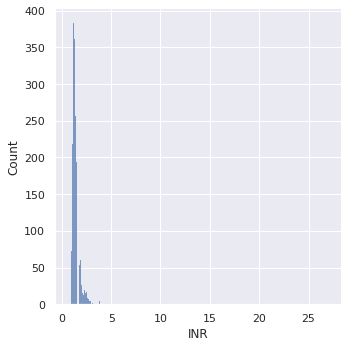

In [84]:
sns.displot(combined_df["INR"])

Given the shape of the distribution, it is unlikely that these high value instances are accurate and more that they are errors in data entry. They may be worth ignoring and imputing.

In [85]:
(non_sep_series["INR"] > 5).value_counts()

False    47081
True         7
Name: INR, dtype: int64

In [86]:
(sep_series["INR"] > 5).value_counts()

False    3017
True        7
Name: INR, dtype: int64

There are only 14 total entries where there are any entries with a value greater than 5. More evidence to impute.

In [87]:
#remove_where("INR", upper=5)

In [88]:
#sns.displot(combined_df["INR"])

### "Magnesium"

In [89]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Magnesium"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Magnesium"].isnull().mean())

Percent of null values in non sepsis :  0.39520426287744226
Percent of null values in sepsis :  0.20689655172413793


Again more values in non sepsis category.

In [90]:
non_sep_series["Magnesium"].describe()

count    1881.000000
mean        2.138437
std         0.417471
min         0.800000
25%         1.900000
50%         2.100000
75%         2.300000
max         4.500000
Name: Magnesium, dtype: float64

In [91]:
sep_series["Magnesium"].describe()

count    137.000000
mean       1.859854
std        0.387765
min        1.000000
25%        1.600000
50%        1.900000
75%        2.100000
max        2.800000
Name: Magnesium, dtype: float64

Mean and STD are not too far apart for this column, the max value for non sepsis is again higher but not massively so.

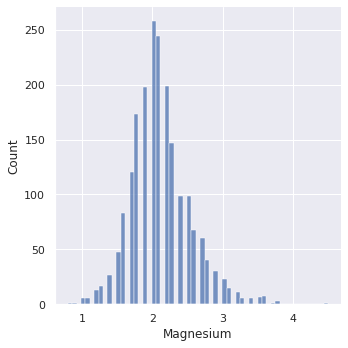

In [92]:
sns.displot(combined_df["Magnesium"])

The distribution looks fairly normally distributed, so there shouldn't be an issue with this feature.

### "NBP Mean"

In [93]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["NBP Mean"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["NBP Mean"].isnull().mean())

Percent of null values in non sepsis :  0.46092362344582594
Percent of null values in sepsis :  0.034482758620689655


Again more values in non sepsis category. Slightly worrying percentage of null patients in the non sepsis category, maybe worth dropping this column.

In [94]:
non_sep_series["NBP Mean"].describe()

count    5404.000000
mean       73.803848
std        13.540250
min         0.000000
25%        64.666702
50%        72.333298
75%        81.333298
max       149.000000
Name: NBP Mean, dtype: float64

In [95]:
sep_series["NBP Mean"].describe()

count    827.000000
mean      72.141880
std       14.374612
min        0.000000
25%       62.833349
50%       71.000000
75%       80.000000
max      145.332993
Name: NBP Mean, dtype: float64

Mean and STD are not too far apart for this column, the max value for non sepsis is again higher but not massively so.

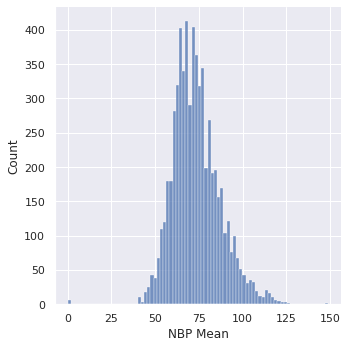

In [96]:
sns.displot(combined_df["NBP Mean"])

Looks fairly normally distributed. Maybe drop values less than 25 or greater than 130.

In [97]:
remove_where("NBP Mean", upper=130, lower=25)

Searching through  NBP Mean
Found  4 values above this range.
Found  6 values below this range.
Succesfully replaced values outside this range with nans.



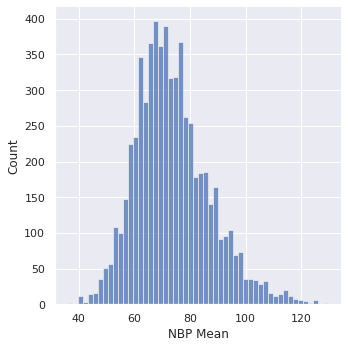

In [98]:
sns.displot(combined_df["NBP Mean"])

### "NBP [Diastolic]"

In [99]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["NBP [Diastolic]"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["NBP [Diastolic]"].isnull().mean())

Percent of null values in non sepsis :  0.458259325044405
Percent of null values in sepsis :  0.02586206896551724


Slightly worrying percentage of null patients in the non sepsis category, maybe worth dropping this column.

In [100]:
non_sep_series["NBP [Diastolic]"].describe()

count    5451.000000
mean       54.465603
std        13.884506
min         0.000000
25%        45.000000
50%        53.000000
75%        63.000000
max       125.000000
Name: NBP [Diastolic], dtype: float64

In [101]:
sep_series["NBP [Diastolic]"].describe()

count    846.000000
mean      55.956265
std       15.009480
min        0.000000
25%       46.000000
50%       56.000000
75%       66.000000
max      129.000000
Name: NBP [Diastolic], dtype: float64

Total column looks pretty identical, min, mean, max, std all looks similar enough.

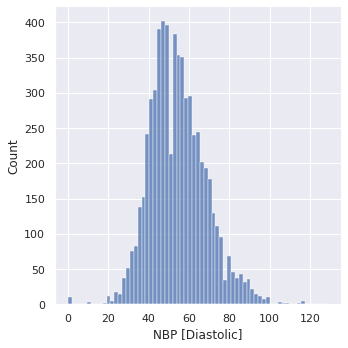

In [102]:
sns.displot(combined_df["NBP [Diastolic]"])

Feature looks nicely distributed.

### "NBP [Systolic]"

In [103]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["NBP [Systolic]"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["NBP [Systolic]"].isnull().mean())

Percent of null values in non sepsis :  0.44493783303730017
Percent of null values in sepsis :  0.02586206896551724


Slightly worrying percentage of null patients in the non sepsis category, maybe worth dropping this column.

In [104]:
non_sep_series["NBP [Systolic]"].describe()

count    5473.000000
mean      114.147040
std        21.738575
min         0.000000
25%       100.000000
50%       112.000000
75%       126.000000
max       234.000000
Name: NBP [Systolic], dtype: float64

In [105]:
sep_series["NBP [Systolic]"].describe()

count    846.000000
mean     110.302600
std       18.795774
min        0.000000
25%       97.000000
50%      108.000000
75%      120.000000
max      189.000000
Name: NBP [Systolic], dtype: float64

General pattern of feature is pretty similar across both patient types, with the maximum value again being higher for non sepsis patients.

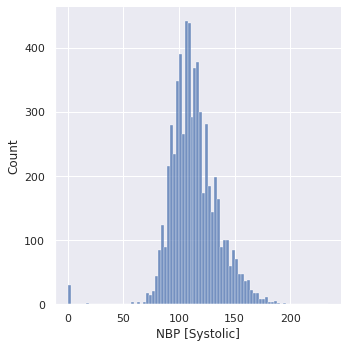

In [106]:
sns.displot(combined_df["NBP [Systolic]"])

May be worth dropping entries less than 50 or greater than 200.

In [107]:
remove_where("NBP [Systolic]", upper=200, lower=50)

Searching through  NBP [Systolic]
Found  4 values above this range.
Found  32 values below this range.
Succesfully replaced values outside this range with nans.



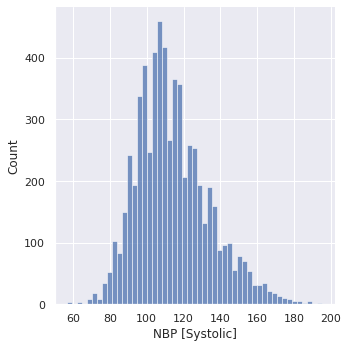

In [108]:
sns.displot(combined_df["NBP [Systolic]"])

### "PTT"

In [109]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["PTT"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["PTT"].isnull().mean())

Percent of null values in non sepsis :  0.39431616341030196
Percent of null values in sepsis :  0.39655172413793105


Similar distribution of patients without this data. Again, alarmingly high percentage of null values though.

In [110]:
non_sep_series["PTT"].describe()

count    1937.000000
mean       41.343211
std        20.785616
min        21.300000
25%        30.400000
50%        35.400000
75%        43.600000
max       150.000000
Name: PTT, dtype: float64

In [111]:
sep_series["PTT"].describe()

count     92.000000
mean      42.694565
std       24.785127
min       25.900000
25%       30.350000
50%       33.500000
75%       44.100000
max      150.000000
Name: PTT, dtype: float64

Feature description very similar, mean and std all very similar.

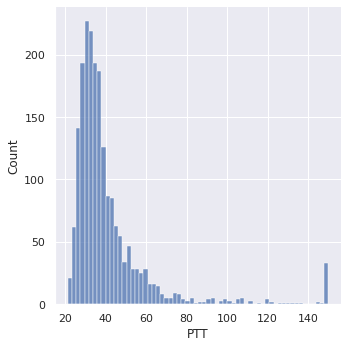

In [112]:
sns.displot(combined_df["PTT"])

Distribution plot shows a large number of instances with a value greater than 140.

In [113]:
(non_sep_series["PTT"] > 140).value_counts()

False    47055
True        33
Name: PTT, dtype: int64

In [114]:
(sep_series["PTT"] > 140).value_counts()

False    3021
True        3
Name: PTT, dtype: int64

These values are almost all in the non sepsis series. Consider removing them, or because of the almost 40% of patients we have no data for maybe remove this feature entirely.

### "Platelets"

- Type of white blood count

In [115]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Platelets"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Platelets"].isnull().mean())

Percent of null values in non sepsis :  0.022202486678507993
Percent of null values in sepsis :  0.21551724137931033


Interestingly this feature has more null instances in the sepsis kind than the non sepsis.

In [116]:
non_sep_series["Platelets"].describe()

count    3222.000000
mean      142.337678
std        65.006060
min        18.000000
25%        97.000000
50%       131.000000
75%       174.000000
max       689.000000
Name: Platelets, dtype: float64

In [117]:
sep_series["Platelets"].describe()

count    130.000000
mean     191.900000
std      109.995127
min       17.000000
25%      105.250000
50%      194.500000
75%      253.500000
max      625.000000
Name: Platelets, dtype: float64

Interestingly, in the sepsis category the mean and std are both greater. The min and maximum are about the same but the spread of values seems that platelets are generally higher. This might make this a good feature indication of sepsis.

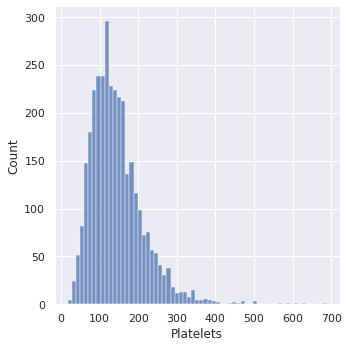

In [118]:
sns.displot(combined_df["Platelets"])

Fairly well distributed, with some high value instances towards the top end. These may well be important to keep.

### "Potassium"

In [119]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Potassium"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Potassium"].isnull().mean())

Percent of null values in non sepsis :  0.3383658969804618
Percent of null values in sepsis :  0.1724137931034483


More values in the sepsis category than not, again seems to follow the trend.

In [120]:
non_sep_series["Potassium"].describe()

count     5717.000000
mean        15.009138
std        810.131474
min          2.300000
25%          3.900000
50%          4.200000
75%          4.600000
max      61259.000000
Name: Potassium, dtype: float64

In [121]:
sep_series["Potassium"].describe()

count    152.000000
mean       4.063816
std        0.704155
min        2.400000
25%        3.500000
50%        4.100000
75%        4.500000
max        6.400000
Name: Potassium, dtype: float64

The 61259 value definitely points to an outlier in the data set. Worth looking into this for the non sepsis series. The data looks fairly normal other than this value.

Interestingly, in the sepsis category the mean and std are both greater. The min and maximum are about the same but the spread of values seems that platelets are generally higher. This might make this a good feature indication of sepsis.

In [122]:
non_sep_series[non_sep_series["Potassium"] > 10]

,PatientID,comorbidity,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH,BUN,CVP,CaO2,Chloride,Creatinine,Daily Weight,Fibrinogen,Glucose,Heart Rate,Hemoglobin,INR,Ionized Calcium,LDH,Magnesium,NBP Mean,NBP [Diastolic],NBP [Systolic],PTT,Platelets,Potassium,Resp Rate (Spont),Respiratory Rate (spontaneous),SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC,Day,OrdinalHour,Sepsis
34765,122310.0,-2.0,0.0,NaN,NaN,NaN,NaN,66.0,51.0,106.0,33.0,116.0,7.43,NaN,10.0,13.095,NaN,NaN,NaN,NaN,105.0,93.0,NaN,NaN,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61259.0,NaN,NaN,NaN,NaN,NaN,99.0,NaN,100.0,NaN,38.200001,NaN,NaN,4.0,13.0,0


In [123]:
(non_sep_series["Potassium"] > 10).value_counts()

False    47087
True         1
Name: Potassium, dtype: int64

In [124]:
(sep_series["Potassium"] > 10).value_counts()

False    3024
Name: Potassium, dtype: int64

Might be worth converting all instances > 10 to NaNs for potassium.

In [125]:
#sns.displot(combined_df["Potassium"])
# i cant actually plot the distribution for potassium as the colab instance crashes because the value is so erroneous and far from the other values in this column.

In [126]:
remove_where("Potassium", upper=10)

Searching through  Potassium
Found  1 values above this range.
Succesfully replaced values outside this range with nans.



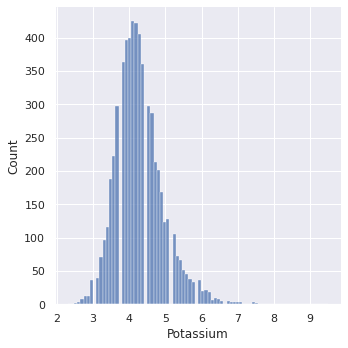

In [127]:
sns.displot(combined_df["Potassium"])

Having replaced that very high value the distribution now looks much more normal. 

### "Sodium"

In [128]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Sodium"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Sodium"].isnull().mean())

Percent of null values in non sepsis :  0.3410301953818828
Percent of null values in sepsis :  0.1810344827586207


More values in the sepsis category than not, again seems to follow the trend.

In [129]:
non_sep_series["Sodium"].describe()

count    2485.000000
mean      138.022942
std         5.435978
min         1.210000
25%       136.000000
50%       138.000000
75%       140.000000
max       164.000000
Name: Sodium, dtype: float64

In [130]:
sep_series["Sodium"].describe()

count    142.000000
mean     139.126761
std        4.847840
min      120.000000
25%      136.250000
50%      139.000000
75%      142.000000
max      154.000000
Name: Sodium, dtype: float64

This feature looks very similar across each category of patient, except for the minimum value of non sepsis patients. This will need to be looked into.

In [131]:
(non_sep_series["Sodium"] < 100).value_counts()

False    47086
True         2
Name: Sodium, dtype: int64

There are only two values, so I will assume they have been entered in error and will replace them below.

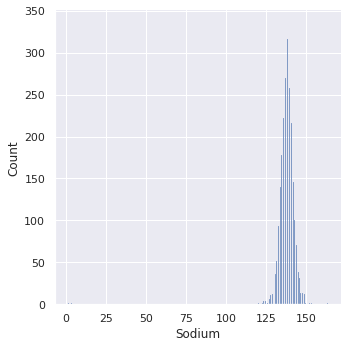

In [132]:
sns.displot(combined_df["Sodium"])

In [133]:
remove_where("Sodium", lower=100)

Searching through  Sodium
Found  2 values below this range.
Succesfully replaced values outside this range with nans.



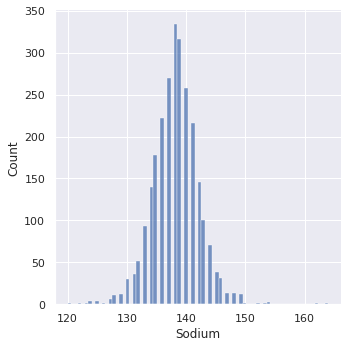

In [134]:
sns.displot(combined_df["Sodium"])

Having replaced the errorenous values, this distribution looks better.

### "SpO2"

- SpO2, also known as oxygen saturation, is a measure of the amount of oxygen-carrying hemoglobin in the blood relative to the amount of hemoglobin not carrying oxygen. The body needs there to be a certain level of oxygen in the blood or it will not function as efficiently.

In [135]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["SpO2"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["SpO2"].isnull().mean())

Percent of null values in non sepsis :  0.0
Percent of null values in sepsis :  0.017241379310344827


Very low percentage of null values in both of these categories. This is a good thing and will make it a useful feature.

In [136]:
non_sep_series["SpO2"].describe()

count    32961.000000
mean        97.267665
std          3.083466
min          0.000000
25%         96.000000
50%         98.000000
75%        100.000000
max        100.000000
Name: SpO2, dtype: float64

In [137]:
sep_series["SpO2"].describe()

count    1016.000000
mean       97.190945
std         4.144313
min        48.000000
25%        96.000000
50%        98.000000
75%       100.000000
max       100.000000
Name: SpO2, dtype: float64

This feature looks very similar across each category of patient, except for the minimum value of non sepsis patients. This will need to be looked into.

In [138]:
(non_sep_series["SpO2"] < 50).value_counts()

False    47076
True        12
Name: SpO2, dtype: int64

In [139]:
(sep_series["SpO2"] < 50).value_counts()

False    3023
True        1
Name: SpO2, dtype: int64

Only 13 entries where the SpO2 value is less than 50. These could be removed as it is unlikely that a patients oxygen saturation would be less than this value. 

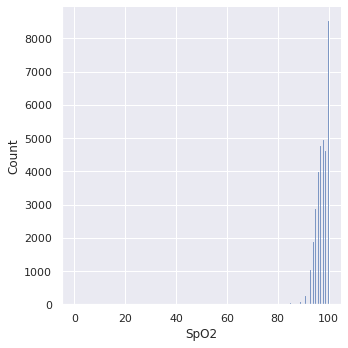

In [140]:
sns.displot(combined_df["SpO2"])

In [141]:
remove_where("SpO2", lower=50)

Searching through  SpO2
Found  13 values below this range.
Succesfully replaced values outside this range with nans.



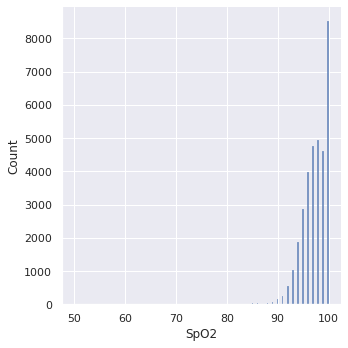

In [142]:
sns.displot(combined_df["SpO2"])

The distribution now looks much more normal.

Will need to ask Zina about this.

### "Temperature C"

In [143]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["Temperature C"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["Temperature C"].isnull().mean())

Percent of null values in non sepsis :  0.0
Percent of null values in sepsis :  0.0


Very low percentage of patients without temperature, this is a good sign of a useful feature.

In [144]:
non_sep_series["Temperature C"].describe()

count    26516.000000
mean        37.235334
std          1.399548
min          0.000000
25%         36.900002
50%         37.299999
75%         37.700001
max         46.500000
Name: Temperature C, dtype: float64

In [145]:
sep_series["Temperature C"].describe()

count    378.000000
mean      36.789536
std        1.007590
min       32.555599
25%       36.166698
50%       36.666698
75%       37.277802
max       40.555599
Name: Temperature C, dtype: float64

The shape of this data is very similar across patient types, with a slightly higher min and max in non sepsis patients but a greater std overall in sepsis patients.

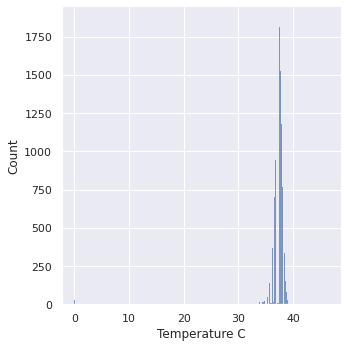

In [146]:
sns.displot(combined_df["Temperature C"])

In [147]:
remove_where("Temperature C", lower=30)

Searching through  Temperature C
Found  30 values below this range.
Succesfully replaced values outside this range with nans.



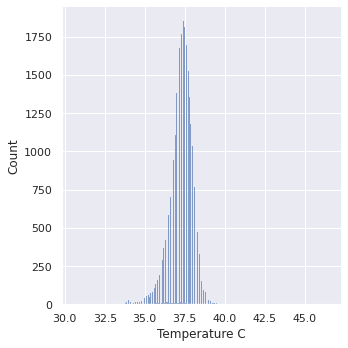

In [148]:
sns.displot(combined_df["Temperature C"])

### "WBC"

In [149]:
# To remove the bias of there being more 48 hour collections in the non sepsis category,
# I have counted only where the imputation has been performed. 
# This means we are now looking at the percentage of patients we do not have any data for.
print("Percent of null values in non sepsis : ", last_entries[last_entries["Sepsis"]==0]["WBC"].isnull().mean())
print("Percent of null values in sepsis : ", last_entries[last_entries["Sepsis"]==1]["WBC"].isnull().mean())

Percent of null values in non sepsis :  0.35079928952042627
Percent of null values in sepsis :  0.23275862068965517


More values in the sepsis category than not, again seems to follow the trend.

In [150]:
non_sep_series["WBC"].describe()

count    2118.000000
mean       12.747691
std         5.523420
min         1.900000
25%         9.000000
50%        11.900000
75%        15.500000
max        48.300000
Name: WBC, dtype: float64

In [151]:
sep_series["WBC"].describe()

count    131.000000
mean      16.538168
std       10.862727
min        0.200000
25%        8.950000
50%       14.600000
75%       21.150000
max       60.200000
Name: WBC, dtype: float64

The mean of these features are roughly simlar, but the standard deviation is almost double for the sepsis patients than not sepsis. This may make it a sueful indicator as other than that the quartiles and min/max are similar.

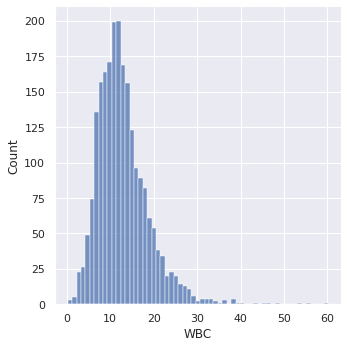

In [152]:
sns.displot(combined_df["WBC"])

Having replaced the errorenous values, this distribution looks better.

# Testing Models

## Functions / Setup

In [153]:
# Will only be using following columns to predict:
predict_cols = ['comorbidity','BUN', 'Chloride', 'Creatinine', 'Glucose', 'Heart Rate', 'Hemoglobin', 'INR', 
 'Magnesium', 'NBP Mean', 'NBP [Diastolic]', 'NBP [Systolic]', 'PTT', 'Platelets',
  'Potassium', 'Sodium', 'SpO2', 'Temperature C', 'WBC', "age", "sofa"]

predict_cols = ['comorbidity','BUN', 'Chloride', 'Creatinine', 'Glucose', 'Heart Rate', 'Hemoglobin', 'INR', 'Magnesium', 'PTT', 'Platelets',
  'Potassium', 'Sodium', 'SpO2', 'Temperature C', 'WBC', "age", "sofa"]

predict_cols = ['comorbidity','BUN', 'Chloride', 'Glucose', 'Heart Rate', 'Hemoglobin', 'Platelets',
  'Potassium', 'Sodium', 'SpO2', 'Temperature C', 'WBC', "age", "sofa"]

target = ["Sepsis"]

In [154]:
scaler = StandardScaler()

In [155]:
pd.options.mode.chained_assignment = None

In [156]:
def fill_nans_by_class(dataset, method="mean", class_wise=False):
    """
    Given a dataset, and a method, fill the nans in the dataset split over class.
    """
    cols = dataset.columns

    if class_wise:
        class0 = dataset[dataset["Sepsis"]==0]
        class1 = dataset[dataset["Sepsis"]==1]
        
        if method=="mean":
            class0.fillna(class0.mean(),inplace=True)
            class1.fillna(class1.mean(),inplace=True)

        if method=="knn":
            imputer = KNNImputer()
            class0 = pd.DataFrame(imputer.fit_transform(class0), columns=dataset.columns)
            class1 = pd.DataFrame(imputer.fit_transform(class1), columns=dataset.columns)

        if method=="missforest":
            imputer = MissForest()
            class0 = pd.DataFrame(imputer.fit_transform(class0), columns=dataset.columns)
            class1 = pd.DataFrame(imputer.fit_transform(class1), columns=dataset.columns)

        filled_dataset = pd.concat([class0,class1])

        return filled_dataset
    
    else:
        
        if method=="mean":
            dataset.fillna(dataset.mean(),inplace=True)

        if method=="knn":
            imputer = KNNImputer()
            transformed = imputer.fit_transform(dataset)

            dataset = pd.DataFrame(transformed, columns=cols)

        if method=="missforest":
            imputer = MissForest()
            dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

        return dataset

In [157]:
def create_dataset_with_hour(hour, imputed_data, fill_nans=False, method=False, class_wise=False):
    """
    Given the specific hour, will select just that to be used for prediction 
    (will take the last version of that though so closest to diagnosis)
    """
    filled = imputed_data.copy(deep=True)

    # Selecting which hour to include in this experiment
    chosen_entries = filled[filled["OrdinalHour"] == hour]

    if hour == 23:
        print("Counts of each class are:")
        print(chosen_entries["Sepsis"].value_counts())
    if fill_nans:
        if not isinstance(method, bool):
            removed_nans = fill_nans_by_class(chosen_entries, method, class_wise)
        else:
            removed_nans = fill_nans_by_class(chosen_entries, class_wise)
    else:
        
        # Removing any rows with nans. Because we already imputed this will only drop rows
        # where there are 0 entries for that patient on one of our useful columns.
        removed_nans = chosen_entries.dropna()

        if hour == 23:
            print("After dropping nans, we have:")
            print(removed_nans["Sepsis"].value_counts())

    # Getting the last entry for this patient, this gives one row per patient
    removed_nans.drop_duplicates(subset=['PatientID'], keep="last", inplace=True)

    # Searching through the list of patient IDs, this is to match the age and sofa
    sepsis_patient_IDs = removed_nans[removed_nans["Sepsis"]==1]["PatientID"]
    non_sepsis_patient_IDs = removed_nans[removed_nans["Sepsis"]==0]["PatientID"]

    age = []
    sofa = []

    for pid in sepsis_patient_IDs:
        row = sep_cohort[sep_cohort["PatientID"] == pid]
        age.append(row["age"].values[0])
        sofa.append(row["sofa"].values[0])

    for pid in non_sepsis_patient_IDs:
        row = non_sep_cohort[non_sep_cohort["PatientID"] == pid]
        age.append(row["age"].values[0])
        sofa.append(row["sofa"].values[0])

    removed_nans["age"] = age
    removed_nans["sofa"] = sofa

    return removed_nans

In [158]:
def run_hours_before_testing(classifier, dataset, fill_nans=False, method=False, class_wise=False):
    accuracy = {}
    recall = {}
    auc = {}
    f1 = {}

    for i in range(23,0,-1):
        selected_dataset = create_dataset_with_hour(i, dataset, fill_nans, method, class_wise)
        
        X = scaler.fit_transform(selected_dataset[predict_cols])
        y = selected_dataset["Sepsis"]
        classifier.fit(X, y.values.ravel())

        accuracy[abs((i-23))] = cross_val_score(classifier, X, y, cv=10, scoring="balanced_accuracy").mean()

        recall[abs((i-23))] = cross_val_score(classifier, X, y, cv=10, scoring="recall").mean()

        auc[abs((i-23))] = cross_val_score(classifier, X, y, cv=10, scoring="roc_auc").mean()

        f1[abs((i-23))] = cross_val_score(classifier, X, y, cv=10, scoring="f1").mean()

    return accuracy, recall, f1, auc

## Dropping Columns before Processing

In [159]:
combined_df.drop(columns=["ALT", "AST", "LDH", "Admit Ht", "Albumin",
                          "CaO2", "Fibrinogen", "Ionized Calcium", 
                          "Resp Rate (Spont)", "SaO2", "Total Bili",
                          "Arterial PaCO2","Arterial PaO2","Arterial pH",
                          "CVP","NBP Mean","NBP [Systolic]","NBP [Diastolic]", "INR", "PTT"], inplace=True)

## Forward Fill

In [160]:
# Imputing using fill forwards followed by fill backwards.
combined_df["PID"] = combined_df["PatientID"]
combined_df["PID2"] = combined_df["PatientID"]
filled = combined_df.groupby(['PID']).ffill()
filled = filled.groupby(['PID2']).bfill()


In [161]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_ffill_m, rec_ffill_m, f1_ffill_m, auc_ffill_m = run_hours_before_testing(clf, filled, fill_nans=True, method="mean", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


In [162]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_ffill_k, rec_ffill_k, f1_ffill_k, auc_ffill_k = run_hours_before_testing(clf, filled, fill_nans=True, method="knn", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


## Linear Interpolation

In [163]:
# Imputing using linear interpolation followed by fill backwards.
combined_df["PID"] = combined_df["PatientID"]
lin_interp = combined_df.groupby(['PID']).apply(lambda group: group.interpolate(method='linear'))
lin_interp.drop(columns=["PID","PID2"], inplace=True)

In [164]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_lin_m, rec_lin_m, f1_lin_m, auc_lin_m  = run_hours_before_testing(clf, lin_interp, fill_nans=True, method="mean", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


In [165]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_lin_k, rec_lin_k, f1_lin_k, auc_lin_k  = run_hours_before_testing(clf, lin_interp, fill_nans=True, method="knn", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


## Mean Interpolation

In [166]:
mean_filled = combined_df.copy()

"""
class0 = mean_filled[mean_filled["Sepsis"]==0]
class1 = mean_filled[mean_filled["Sepsis"]==1]
class0.fillna(class0.mean(),inplace=True)
class1.fillna(class1.mean(),inplace=True)

mean_filled = pd.concat([class0,class1])
"""

mean_filled.fillna(mean_filled.mean(), inplace=True)


In [167]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_mean, rec_mean, f1_mean, auc_mean = run_hours_before_testing(clf, mean_filled, fill_nans=False, method=False, class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64
After dropping nans, we have:
0    1962
1     126
Name: Sepsis, dtype: int64


## Gaussian Process

In [168]:
#iterate through data set
def impute_with_GPR(dataset, req_non_nulls=2):
    column_list = ['BUN', 'Chloride', 'Creatinine', 'Daily Weight', 'Glucose', 
                   'Hemoglobin', 'Magnesium', 'Platelets', 
                   'Potassium', 'Sodium', 'SpO2', 'Temperature C', 'WBC',]

    # find patient
    patient_IDs = dataset["PatientID"].unique()

    # n is number of patients
    n = 1242

    for count,pID in enumerate(patient_IDs):
        # get data for patient

        j = (count + 1) / n
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()

        patient_data = dataset[dataset["PatientID"] == pID]

        # go through columns
        for col in column_list:

            column_mean = combined_df[col].mean()

            target_values = patient_data[col]

            if len(target_values.values) - target_values.isna().sum() >= 2:
                #only impute if there are at least 2 non null values

                transformed_feature = (target_values.values.reshape(-1, 1))

                frame_entry = pd.DataFrame(transformed_feature)

                not_null_index_list = frame_entry.dropna().index.tolist()

                frame_entry = frame_entry - column_mean

                #  Take the input data
                X = np.atleast_2d(not_null_index_list).T
                # Take the observations
                y = np.atleast_2d(frame_entry.dropna().values.tolist()).T.reshape(-1,1)

                kernel = GPy.kern.RBF(1) * GPy.kern.Linear(1)

                # feed data into the model
                m = GPy.models.GPRegression(X,y,kernel)

                #m.optimize_restarts(num_restarts = 5, verbose=False)

                output_preds = np.array(np.arange(len(target_values.values))).reshape(-1, 1)

                # get predictions
                predictions = pd.DataFrame(m.predict(output_preds)[0]) + column_mean

                # put predictions back into patient data
                counter=0
                indexes = dataset[dataset["PatientID"] == pID].index
                dataset.at[indexes, col] = predictions[0]

    return dataset


In [169]:
# this takes ages - could probably be sped up with paralelisation better, but difficult and not sure if possible in time allowed
# definitely could speed up a bit, worth talking about this in the report
# still hopefully quicker than the missforest method though

# took 17minutes first time round with poor code optimisation and no optimisation of gpr model
# took 22 minutes after improving code optimisation slightly and now also omptimizing model
# took 1 hour and a half using MLP kernel (it is a NN so that makes sense) (was optimised 5 restarts)

In [170]:
gpr_filled = combined_df.copy()

gpr_filled.drop(columns=["PID", "PID2"], inplace=True)


In [171]:
gpr_filled = impute_with_GPR(gpr_filled, req_non_nulls=2)

[====================] 100%

In [172]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_gpr_m, rec_gpr_m, f1_gpr_m, auc_gpr_m = run_hours_before_testing(clf, gpr_filled, fill_nans=True, method="mean", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


In [173]:
clf = svm.SVC(C=3, kernel="linear", class_weight="balanced")
acc_gpr_k, rec_gpr_k, f1_gpr_k, auc_gpr_k = run_hours_before_testing(clf, gpr_filled, fill_nans=True, method="knn", class_wise=False)
#returned_transformed_knn = run_hours_before_testing(clf, gpr_filled, fill_nans=True, method="knn", class_wise=False)

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


## Printing  Graphs

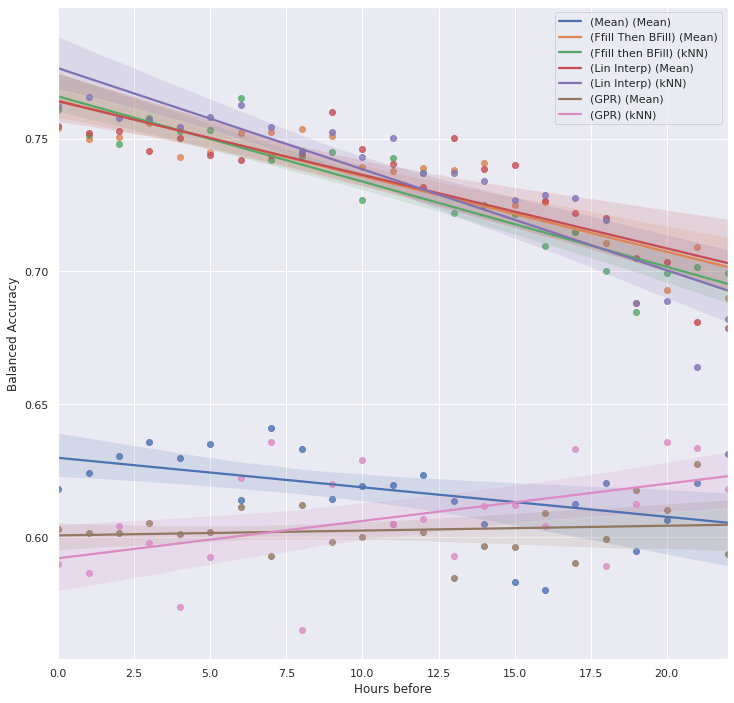

In [174]:
#Mean Filled (SVM)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_mean.keys()
df["Balanced Accuracy"] = acc_mean.values()
ax = sns.regplot(data=df, x="Hours before", y="Balanced Accuracy")

##################

#FFill (SVM) (Mean filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_ffill_m.keys()
df["Balanced Accuracy"] = acc_ffill_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Balanced Accuracy")

#FFill (SVM) (knn filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_ffill_k.keys()
df["Balanced Accuracy"] = acc_ffill_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Balanced Accuracy")

##################

#Linear Interpolation (SVM) (Mean filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_lin_m.keys()
df["Balanced Accuracy"] = acc_lin_m.values()
ax = sns.regplot(ax =ax, data=df, x="Hours before", y="Balanced Accuracy")

#Linear Interpolation (SVM) (knn filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_lin_k.keys()
df["Balanced Accuracy"] = acc_lin_k.values()
ax = sns.regplot(ax =ax, data=df, x="Hours before", y="Balanced Accuracy")

##################


#GPR (SVM) (Mean filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_gpr_m.keys()
df["Balanced Accuracy"] = acc_gpr_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Balanced Accuracy")

#GPR (SVM) (knn filled)
df = pd.DataFrame(columns=["Hours before", "Balanced Accuracy"])
df["Hours before"] = acc_gpr_k.keys()
df["Balanced Accuracy"] = acc_gpr_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Balanced Accuracy")


##################


ax.legend(labels=['(Mean) (Mean)', '(Ffill Then BFill) (Mean)', 
                  '(Ffill then BFill) (kNN)', '(Lin Interp) (Mean)', 
                  '(Lin Interp) (kNN)','(GPR) (Mean)', '(GPR) (kNN)'])

#Set to caption
#ax.set_title('Balanced Accuracy as time from final data entry increases - Format = (Interp Method) (Classifier) (Fill Method)')


plt.savefig('balanced_accuracy.pdf')

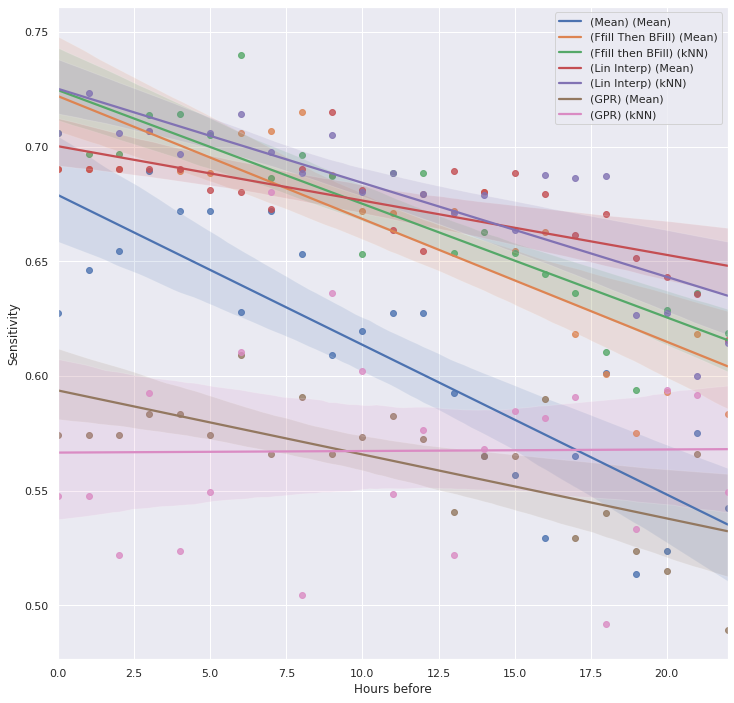

In [175]:
#################

# Mean (SVM)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_mean.keys()
df["Sensitivity"] = rec_mean.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#################

#FFill (SVM) (Mean)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_ffill_m.keys()
df["Sensitivity"] = rec_ffill_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#FFill (SVM) (kNN)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_ffill_k.keys()
df["Sensitivity"] = rec_ffill_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#################

#Linear Interpolation (SVM) (Mean)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_lin_m.keys()
df["Sensitivity"] = rec_lin_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#Linear Interpolation (SVM) (kNN)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_lin_k.keys()
df["Sensitivity"] = rec_lin_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#################

#GPR (SVM) (Mean filled)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_gpr_m.keys()
df["Sensitivity"] = rec_gpr_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")

#GPR (SVM) (knn filled)
df = pd.DataFrame(columns=["Hours before", "Sensitivity"])
df["Hours before"] = rec_gpr_k.keys()
df["Sensitivity"] = rec_gpr_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Sensitivity")


ax.legend(labels=['(Mean) (Mean)', '(Ffill Then BFill) (Mean)', 
                  '(Ffill then BFill) (kNN)', '(Lin Interp) (Mean)', 
                  '(Lin Interp) (kNN)','(GPR) (Mean)', '(GPR) (kNN)'])
# Set to caption
#ax.set_title('Sensitivity as time from final data entry increases - Format = (Interp Method) (Classifier) (Fill Method - (Not Class-wise))')

plt.savefig('sensitivity_comparison.pdf')

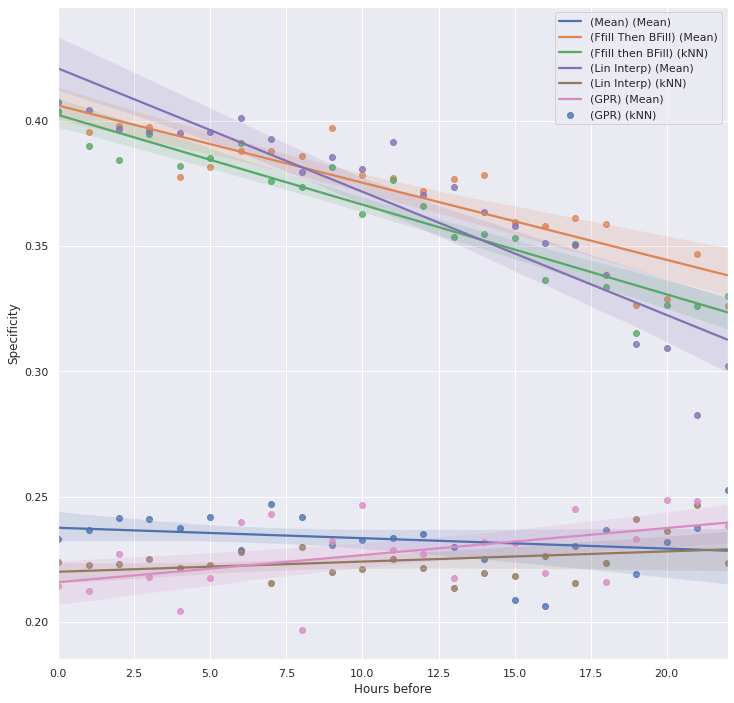

In [176]:
###############

#Mean (SVM)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_mean.keys()
df["Specificity"] = f1_mean.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

#################

#FFill (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_ffill_m.keys()
df["Specificity"] = f1_ffill_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

#FFill (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_ffill_k.keys()
df["Specificity"] = f1_ffill_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

###############

#Linear Interpolation (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_lin_m.keys()
df["F1"] = f1_lin_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

#Linear Interpolation (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_lin_k.keys()
df["Specificity"] = f1_lin_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

###############

#GPR (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_gpr_m.keys()
df["Specificity"] = f1_gpr_m.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")

#GPR (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "Specificity"])
df["Hours before"] = f1_gpr_k.keys()
df["Specificity"] = f1_gpr_k.values()
ax = sns.regplot(data=df, x="Hours before", y="Specificity")


ax.legend(labels=['(Mean) (Mean)', '(Ffill Then BFill) (Mean)', 
                  '(Ffill then BFill) (kNN)', '(Lin Interp) (Mean)', 
                  '(Lin Interp) (kNN)','(GPR) (Mean)', '(GPR) (kNN)'])


plt.savefig('Specificity_comparison.pdf')

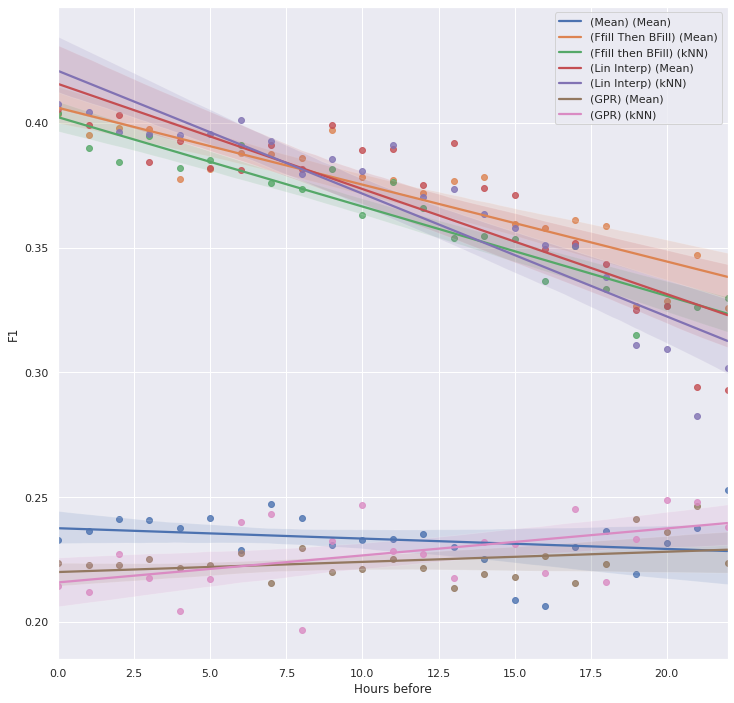

In [177]:
###############

#Mean (SVM)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_mean.keys()
df["F1"] = f1_mean.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

#################

#FFill (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_ffill_m.keys()
df["F1"] = f1_ffill_m.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

#FFill (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_ffill_k.keys()
df["F1"] = f1_ffill_k.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

###############

#Linear Interpolation (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_lin_m.keys()
df["F1"] = f1_lin_m.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

#Linear Interpolation (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_lin_k.keys()
df["F1"] = f1_lin_k.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

###############

#GPR (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_gpr_m.keys()
df["F1"] = f1_gpr_m.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")

#GPR (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "F1"])
df["Hours before"] = f1_gpr_k.keys()
df["F1"] = f1_gpr_k.values()
ax = sns.regplot(data=df, x="Hours before", y="F1")


ax.legend(labels=['(Mean) (Mean)', '(Ffill Then BFill) (Mean)', 
                  '(Ffill then BFill) (kNN)', '(Lin Interp) (Mean)', 
                  '(Lin Interp) (kNN)','(GPR) (Mean)', '(GPR) (kNN)'])


plt.savefig('f1_comparison.pdf')

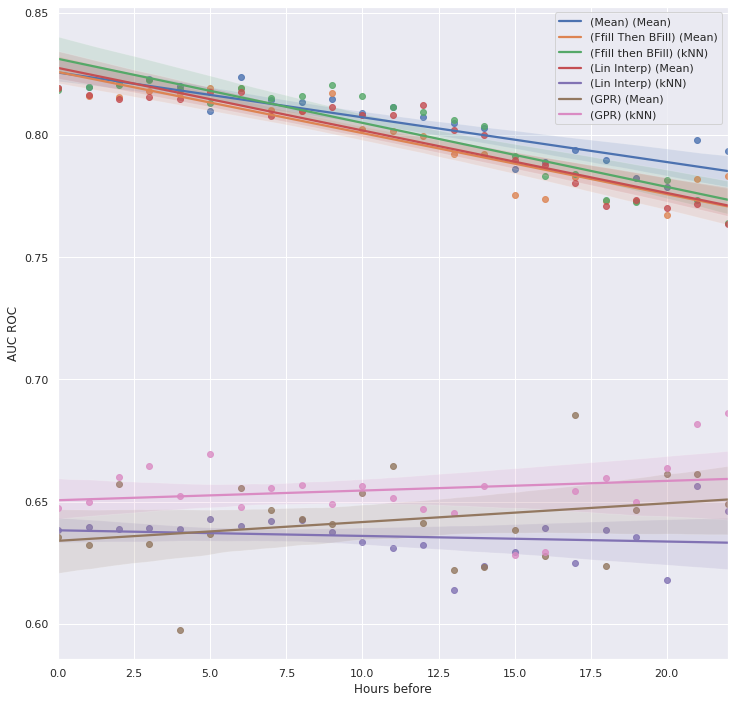

In [178]:
#FFill (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_ffill_m.keys()
df["AUC ROC"] = auc_ffill_m.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

#FFill (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_ffill_k.keys()
df["AUC ROC"] = auc_ffill_k.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

###############

#Linear Interpolation (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_lin_m.keys()
df["AUC ROC"] = auc_lin_m.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

#Linear Interpolation (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_lin_k.keys()
df["AUC ROC"] = auc_lin_k.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

###############

#GPR (SVM) (Mean Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_gpr_m.keys()
df["AUC ROC"] = auc_gpr_m.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")


#GPR (SVM) (kNN Filled)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_gpr_k.keys()
df["AUC ROC"] = auc_gpr_k.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

###############

#Mean (SVM)
df = pd.DataFrame(columns=["Hours before", "AUC ROC"])
df["Hours before"] = auc_mean.keys()
df["AUC ROC"] = auc_mean.values()
ax = sns.regplot(data=df, x="Hours before", y="AUC ROC")

#################

ax.legend(labels=['(Mean) (Mean)', '(Ffill Then BFill) (Mean)', 
                  '(Ffill then BFill) (kNN)', '(Lin Interp) (Mean)', 
                  '(Lin Interp) (kNN)','(GPR) (Mean)', '(GPR) (kNN)'])

plt.savefig('auc_roc_comparison.pdf')

## Grid Search

In [179]:
from sklearn.model_selection import GridSearchCV

In [180]:
selected_dataset = create_dataset_with_hour(23, lin_interp, fill_nans=True, method="knn")
X = scaler.fit_transform(selected_dataset[predict_cols])
y = selected_dataset["Sepsis"]

Counts of each class are:
0    1962
1     126
Name: Sepsis, dtype: int64


### kNN

In [181]:
parameters = {"weights":('uniform', 'distance'), 'n_neighbors':[4,5,6]}
neigh = KNeighborsClassifier()
clf = GridSearchCV(neigh, parameters, scoring="balanced_accuracy")
clf.fit(X, y)
#sorted(clf.cv_results_.keys())

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [4, 5, 6],
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [182]:
clf.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [183]:
clf.best_score_

0.5612087982557394

### SVM

In [184]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1,2,3,4,5,5,6,7,8,9,10], 'class_weight':("balanced", None)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring="balanced_accuracy")
clf.fit(X, y)
#sorted(clf.cv_results_.keys())

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10],
                         'class_weight': ('balanced', None),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [185]:
clf.best_params_

{'C': 9, 'class_weight': 'balanced', 'kernel': 'linear'}

In [186]:
clf.best_score_

0.7416446710273182